In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATADIR = '/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets'

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/models/facenet_keras.h5 /content/

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 3023
n_features: 1850
n_classes: 62


In [ ]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [ ]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
from keras.models import load_model, Model
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score

model = load_model("/content/facenet_keras.h5")

batch_size = 128

def run_algorithm(X):
    """
    Runs the HyperParameter Tuning for Effective Clustering
    """

    idx = 0
    homogeneity_train_dict = {}
    homogeneity_dict = {}
    completeness_train_dict = {}
    completeness_dict = {}
    v_measure_train_dict = {}
    v_measure_dict = {}
    ari_train_dict = {}
    ari_dict = {}
    ami_train_dict = {}
    ami_dict = {}

    for eps in tqdm(range(1, 12, 3)):
      for min_samples in range(1, 20, 5):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        images = []
        for x in X:
          images.append(cv2.resize(x.reshape(50,37), (160,160)))
        images = np.stack(images)
        images = np.concatenate([np.expand_dims(images, 3)]*3, axis=2)
        images = l2_normalize(prewhiten(images.reshape(-1,160,160,3)))
        emb = []
        for ii in tqdm(range(0, len(images), batch_size)):
          emb.append(model.predict(images[ii:ii+batch_size]))
        emb = np.vstack(emb)
        db.fit(euclidean_distances(emb))
        labels = db.labels_

        homogeneity_dict[(eps, min_samples)] = homogeneity_score(y, labels)
        completeness_dict[(eps, min_samples)] = completeness_score(y, labels)
        v_measure_dict[(eps, min_samples)] = v_measure_score(y, labels)
        ari_dict[(eps, min_samples)] = adjusted_rand_score(y, labels)
        ami_dict[(eps, min_samples)] = normalized_mutual_info_score(y, labels)

    return homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict

In [ ]:
homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict = run_algorithm(X)

100%|██████████| 24/24 [01:27<00:00,  3.64s/it]

100%|██████████| 24/24 [01:26<00:00,  3.60s/it]

100%|██████████| 24/24 [01:27<00:00,  3.64s/it]

100%|██████████| 24/24 [01:28<00:00,  3.69s/it]

100%|██████████| 24/24 [01:30<00:00,  3.78s/it]

100%|██████████| 24/24 [01:26<00:00,  3.60s/it]

100%|██████████| 24/24 [01:28<00:00,  3.67s/it]

100%|██████████| 24/24 [01:28<00:00,  3.67s/it]

100%|██████████| 24/24 [01:32<00:00,  3.87s/it]

100%|██████████| 24/24 [01:25<00:00,  3.55s/it]

100%|██████████| 24/24 [01:25<00:00,  3.58s/it]

100%|██████████| 24/24 [01:25<00:00,  3.58s/it]

100%|██████████| 4/4 [25:01<00:00, 375.29s/it]


In [ ]:
homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict

({(1, 1): 1.0000000000000004,
  (1, 6): 0.0,
  (1, 11): 0.0,
  (1, 16): 0.0,
  (4, 1): 1.0000000000000004,
  (4, 6): 0.0,
  (4, 11): 0.0,
  (4, 16): 0.0,
  (7, 1): 0.9988748598428571,
  (7, 6): 0.0,
  (7, 11): 0.0,
  (7, 16): 0.0,
  (10, 1): 0.8342417205099455,
  (10, 6): 0.02460199624630689,
  (10, 11): 0.0051192350050653064,
  (10, 16): 0.0027457131505907837},
 {(1, 1): 0.4577238950103615,
  (1, 6): 1.0,
  (1, 11): 1.0,
  (1, 16): 1.0,
  (4, 1): 0.4577238950103615,
  (4, 6): 1.0,
  (4, 11): 1.0,
  (4, 16): 1.0,
  (7, 1): 0.4575230594659242,
  (7, 6): 1.0,
  (7, 11): 1.0,
  (7, 16): 1.0,
  (10, 1): 0.43152111206043686,
  (10, 6): 0.2353637518944223,
  (10, 11): 0.21455754682897846,
  (10, 16): 0.24302104258294577},
 {(1, 1): 0.6279980681898722,
  (1, 6): 0.0,
  (1, 11): 0.0,
  (1, 16): 0.0,
  (4, 1): 0.6279980681898722,
  (4, 6): 0.0,
  (4, 11): 0.0,
  (4, 16): 0.0,
  (7, 1): 0.6275871117912613,
  (7, 6): 0.0,
  (7, 11): 0.0,
  (7, 16): 0.0,
  (10, 1): 0.5688157460440307,
  (10, 6): 0

In [ ]:
images2 = []
files = []
for ij, str_samp in tqdm(enumerate(metadata_CACD.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = os.path.join(DATADIR, 'CACD2000', 'CACD2000', filename2)
    if os.path.isfile(img2):
      image2 = cv2.resize(imageio.imread(img2), (160,160))
      files.append(filename2)
      if len(image2.shape) == 2:
        image2 = np.concatenate([np.expand_dims(image2, 2)]*3, axis=2)
      images2.append(image2)
    if ij == 5000:
      break

5000it [00:08, 574.24it/s]


In [ ]:
images2 = np.stack(images2)

In [ ]:
from keras.models import load_model, Model
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score

model = load_model("/content/facenet_keras.h5")

batch_size = 128

def run_algorithm(X):
    """
    Runs the HyperParameter Tuning for Effective Clustering
    """

    idx = 0

    eps = 12
    min_samples = 1
    
    db = DBSCAN(eps=eps, min_samples=min_samples)
    images3 = l2_normalize(prewhiten(images2.reshape(-1,160,160,3)))
    emb = []
    for ii in tqdm(range(0, len(images2), batch_size)):
      emb.append(model.predict(images2[ii:ii+batch_size]))
    emb = np.vstack(emb)
    db.fit(euclidean_distances(emb))
    labels = db.labels_

    ages = [f.split("_")[0] for f in files]

    cluster_labels = pd.DataFrame()
    cluster_labels['ages'] = ages
    cluster_labels['labels'] = labels
    cluster_labels['eps'] = eps
    cluster_labels['min_samples'] = min_samples

    return cluster_labels

In [ ]:
cluster_labels = run_algorithm(None)

100%|██████████| 12/12 [00:46<00:00,  3.91s/it]


In [ ]:
cluster_labels

,ages,labels,eps,min_samples
0,53,0,12,1
1,54,1,12,1
2,54,2,12,1
3,54,3,12,1
4,54,4,12,1
...,...,...,...,...
1453,56,1444,12,1
1454,56,1445,12,1
1455,56,1446,12,1
1456,58,1447,12,1


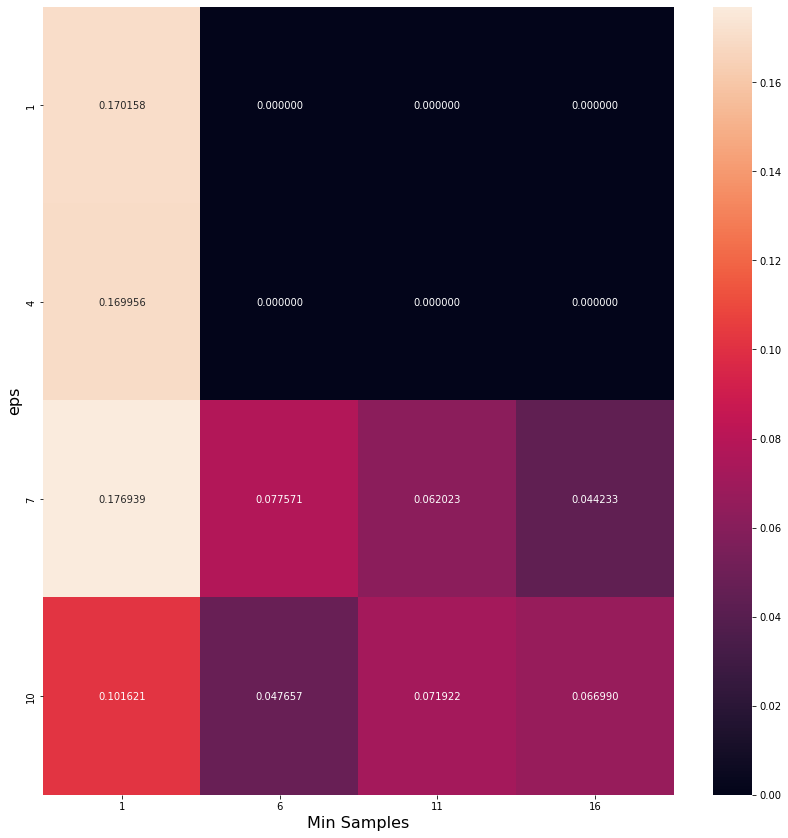

In [ ]:
import seaborn as sns

# Heatmap visualization of LogitBoost Algorithm
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(data=np.array([v for (eps, ms), v in list(ami_dict.items())]).reshape(-1,4), ax=ax, annot=True, fmt="f")
ax.set_yticklabels([1,4,7,10])
ax.set_xticklabels([1,6,11,16])
ax.set_xlabel("Min Samples", fontsize=16)
ax.set_ylabel("eps", fontsize=16)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
rse = pd.read_csv("rolling-standard-error-cacd-agedb.csv", index_col=0)

In [ ]:
rse.mean(axis=1).loc[[30, 50, 70, 90]]

30    0.040837
50    0.024328
70    0.027452
90    0.044983
dtype: float64

In [ ]:
rse.sem(axis=1).loc[[30, 50, 70, 90]]

30    0.000440
50    0.000221
70    0.000166
90    0.000226
dtype: float64

In [ ]:
rse

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
38,0.013206,0.014095,0.015946,0.015023,0.014657,0.015218,0.013494,0.014692,0.014301,0.013890,...,0.015106,0.015195,0.014326,0.013692,0.014357,0.014514,0.015093,0.014228,0.015397,0.013780
39,0.012865,0.013998,0.015696,0.014764,0.014476,0.014771,0.013255,0.014383,0.014078,0.013750,...,0.014748,0.014814,0.014003,0.013458,0.013957,0.014106,0.014728,0.014037,0.014982,0.013452
40,0.012700,0.013780,0.015521,0.014389,0.014155,0.014582,0.013057,0.014107,0.013815,0.013518,...,0.014520,0.014552,0.013650,0.013176,0.013735,0.013910,0.014435,0.013769,0.014667,0.013230
41,0.012664,0.013601,0.015346,0.014222,0.014108,0.014321,0.012785,0.013840,0.013749,0.013525,...,0.014281,0.014412,0.013475,0.012914,0.013731,0.013684,0.014201,0.013616,0.014366,0.012923
42,0.012558,0.013263,0.014892,0.014173,0.013924,0.014592,0.012640,0.013670,0.013798,0.013472,...,0.014041,0.014109,0.013411,0.012763,0.013771,0.013599,0.013972,0.013604,0.014023,0.012885
43,0.012473,0.013196,0.014807,0.014086,0.013800,0.014498,0.012552,0.013585,0.013506,0.013495,...,0.013872,0.013949,0.013557,0.012662,0.013835,0.013558,0.014091,0.013421,0.013840,0.012804
44,0.012449,0.013279,0.014723,0.013923,0.013840,0.014306,0.012587,0.013559,0.013264,0.013485,...,0.013857,0.013803,0.013490,0.012599,0.013852,0.013279,0.014085,0.013289,0.013879,0.012809
45,0.012694,0.013522,0.014691,0.013891,0.013654,0.014188,0.012493,0.013335,0.013107,0.013615,...,0.013678,0.013931,0.013417,0.012686,0.013850,0.013133,0.014101,0.013322,0.013764,0.012598
46,0.012755,0.013354,0.014440,0.013969,0.013589,0.014013,0.012679,0.013346,0.013041,0.013672,...,0.013639,0.014149,0.013470,0.012725,0.013807,0.013267,0.014073,0.013384,0.013891,0.012752
47,0.012983,0.013541,0.014363,0.014180,0.013738,0.014141,0.012828,0.013661,0.013294,0.013778,...,0.013658,0.014490,0.013435,0.012885,0.013886,0.013509,0.014260,0.013378,0.013878,0.012889


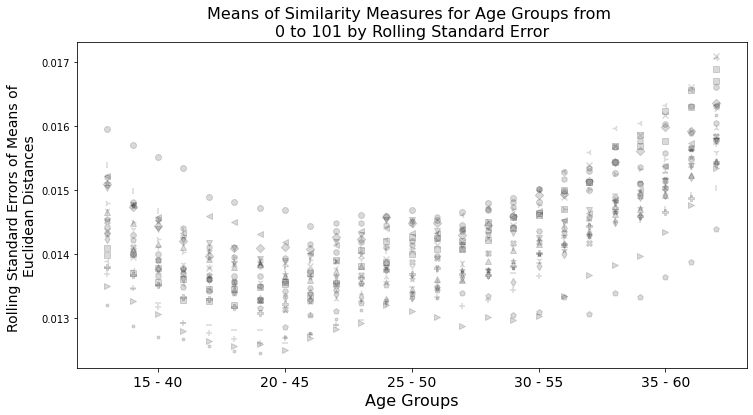

In [ ]:
markers = {
    0: "."	,
    1: ","	,
    2: "o"	,
    3: "v"	,
    4: "^"	,
    5: "<"	,
    6: ">"	,
    7: "1"	,
    8: "2"	,
    9: "3"	,
    10: "4"	,
    11: "8"	,
    12: "s"	,
    13: "p"	,
    14: "P"	,
    15: "*"	,
    16: "h"	,
    17: "H"	,
    18: "+"	,
    19: "x"	,
    20: "X",	
    21: "D"	,
    22: "d"	,
    23: "|"	,
    24: "_"
}
fig, ax = plt.subplots(1,1,figsize=(12,6))
for idx, col in rse.iteritems():
  ax.scatter(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Standard Error", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Standard Errors of Means of \nEuclidean Distances", fontsize=14)
ax.set_xticks([40,45,50,55,60])
ax.set_xticklabels(['15 - 40', '20 - 45', '25 - 50', '30 - 55', '35 - 60'], fontsize=14)
fig.show()

In [ ]:
rsd = pd.read_csv("rolling-std-dev-cacd-agedb.csv", index_col=0)

In [ ]:
rsd.mean(axis=1).loc[[30, 50, 70, 90]]

30    2.387461
50    2.220624
70    2.138095
90    2.302033
dtype: float64

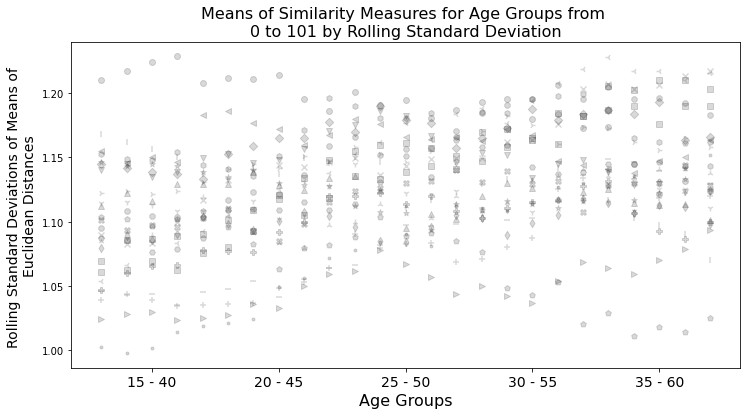

In [ ]:
markers = {
    0: "."	,
    1: ","	,
    2: "o"	,
    3: "v"	,
    4: "^"	,
    5: "<"	,
    6: ">"	,
    7: "1"	,
    8: "2"	,
    9: "3"	,
    10: "4"	,
    11: "8"	,
    12: "s"	,
    13: "p"	,
    14: "P"	,
    15: "*"	,
    16: "h"	,
    17: "H"	,
    18: "+"	,
    19: "x"	,
    20: "X",	
    21: "D"	,
    22: "d"	,
    23: "|"	,
    24: "_"
}
fig, ax = plt.subplots(1,1,figsize=(12,6))
for idx, col in rsd.iteritems():
  ax.scatter(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Standard Deviation", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Standard Deviations of Means of \nEuclidean Distances", fontsize=14)
ax.set_xticks([40,45,50,55,60])
ax.set_xticklabels(['15 - 40', '20 - 45', '25 - 50', '30 - 55', '35 - 60'], fontsize=14)
fig.show()

In [ ]:
med = pd.read_csv("rolling-mean-euclidean-distances-cacd-agedb.csv", index_col=0)

In [ ]:
med.mean(axis=1).loc[[30, 50, 70, 90]]

30    0.496518
50    0.540291
70    0.576184
90    0.579703
dtype: float64

In [ ]:
med.sem(axis=1).loc[[30, 50, 70, 90]]

30    0.003755
50    0.003223
70    0.002638
90    0.002472
dtype: float64

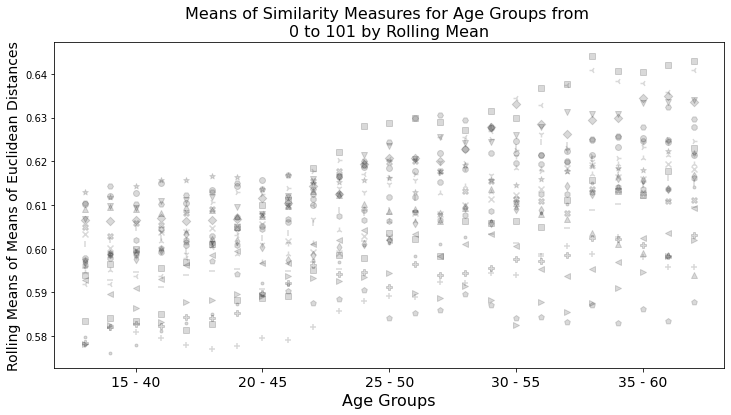

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
for idx, col in med.iteritems():
  ax.scatter(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Mean", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Means of Euclidean Distances", fontsize=14)
ax.set_xticks([40,45,50,55,60])
ax.set_xticklabels(['15 - 40', '20 - 45', '25 - 50', '30 - 55', '35 - 60'], fontsize=14)
fig.show()

In [ ]:
db = DBSCAN(eps=0.1, min_samples=1)
db.fit(rsd)

DBSCAN(eps=0.1, min_samples=1)

In [ ]:
rsd.shape

(76, 25)

In [ ]:
db.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 14,
       14, 15, 16, 16, 17, 17, 17, 18, 19, 20, 20, 20, 21, 21, 22, 23, 24,
       25, 26, 27, 28, 28, 29, 29, 30, 30, 31, 32, 32, 33, 33, 33, 34, 34,
       35, 35, 36, 37, 37, 37, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55])

In [ ]:
db = DBSCAN(eps=0.02, min_samples=1)
db.fit(med)

DBSCAN(eps=0.02, min_samples=1)

In [ ]:
med.shape

(76, 25)

In [ ]:
db.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 15, 16, 17, 18, 18, 19, 19, 20, 20, 21,
       22, 23, 24, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28,
       29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 33, 34, 34, 35, 35, 35, 36,
       36, 37, 38, 39, 40, 41, 42, 43])

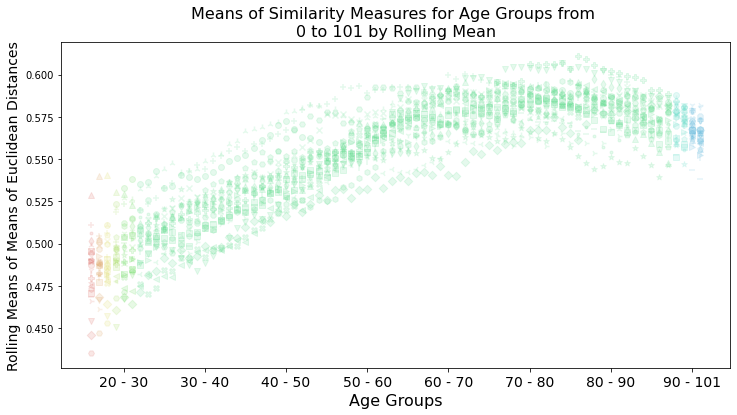

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
colors = sns.color_palette("hls", 13)
for idx, col in med.iteritems():
  for i in range(13):
    ax.scatter(col.index[db.labels_==i], col.values[db.labels_==i], marker=markers[int(idx)], c=colors[i], alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Mean", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Means of Euclidean Distances", fontsize=14)
ax.set_xticks([30,40,50,60,70,80,90,100])
ax.set_xticklabels(['20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 101'], fontsize=14)
fig.show()

https://towardsdatascience.com/preserving-geodesic-distance-for-non-linear-datasets-isomap-d24a1a1908b2

500it [00:01, 486.46it/s]


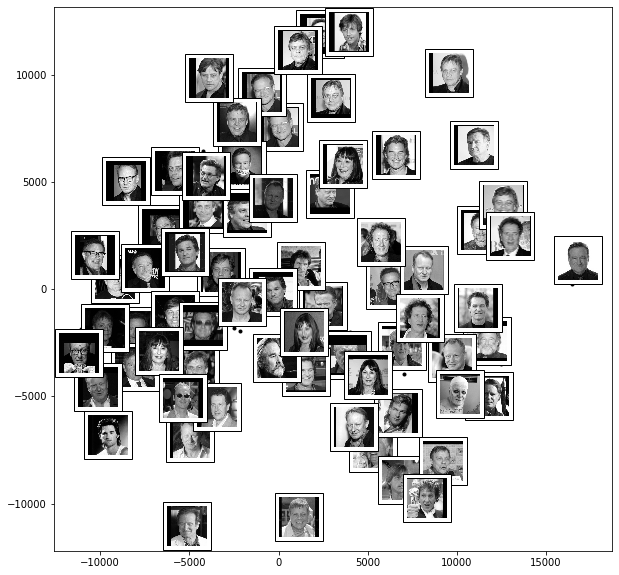

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from matplotlib.offsetbox import AnnotationBbox
from matplotlib import offsetbox
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_lfw_people
import os
import scipy.io
import imageio
# faces = fetch_lfw_people(min_faces_per_person=40)

mat = scipy.io.loadmat(os.path.join(DATADIR, "celebrity2000_meta.mat"))
age, identity, year, feature_1, feature_2, feature_3, feature_4, name = mat['celebrityImageData'][0][0]
metadata_CACD = pd.DataFrame(np.vstack([age.flatten(), identity.flatten(), year.flatten(), 
                            np.array(list(map(lambda x: x.tolist()[0][0].split("_")[1] + "_" + x.tolist()[0][0].split("_")[2], name))), 
                            np.array(list(map(lambda x: x.tolist()[0][0], name)))]).T, 
                  columns=['age', 'identity', 'year', 'name', 'filename'])
metadata_CACD['age'] = metadata_CACD['age'].astype(int)
metadata_CACD['identity'] = metadata_CACD['identity'].astype(int)
metadata_CACD['year'] = metadata_CACD['year'].astype(int)

images2 = []
for ij, str_samp in tqdm(enumerate(metadata_CACD.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = os.path.join(DATADIR, 'CACD2000', 'CACD2000', filename2)
    if os.path.isfile(img2):
      image2 = cv2.resize(imageio.imread(img2), (80,80))
      if len(image2.shape) == 3:
          image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
      images2.append(image2)
    if ij == 500:
      break

images2 = np.vstack(images2)

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

from sklearn.manifold import Isomap
# model = Isomap(n_components=2)
# proj = model.fit_transform()
# proj.shape

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(images2.reshape(-1,80,80).reshape(-1,80*80),
                model=Isomap(n_components=2),
                images=images2.reshape(-1,80,80)[:, ::2, ::2])

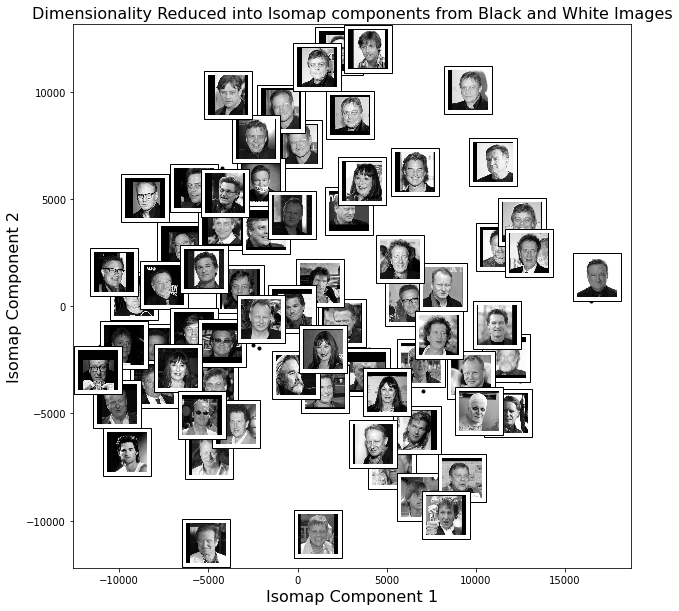

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(images2.reshape(-1,80,80).reshape(-1,80*80),
                model=Isomap(n_components=2),
                images=images2.reshape(-1,80,80)[:, ::2, ::2])
plt.xlabel("Isomap Component 1", fontsize=16)
plt.ylabel("Isomap Component 2", fontsize=16)
plt.title("Dimensionality Reduced into Isomap components from Black and White Images", fontsize=16)
plt.show()

In [ ]:
#import packages for use later in the HMM code

import pandas as pd
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import datetime as dt

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

import seaborn as sns
from sklearn.model_selection import train_test_split

# X_train, X_test = train_test_split(med, test_size=0.2, random_state=42)

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(med)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(med)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()


# sns.set(font_scale=1.5)
# states = (pd.DataFrame(hidden_states, columns=['states'], index=X_test.index)
#           .join(X_test, how='inner')
#           .reset_index(drop=False)
#           .rename(columns={'index':'Date'}))
# states.head()

#Identify state in 2020-03-12-->Crisis state-->Embed in title
# row_index = states[states['date'] == '2020-03-12'].index.tolist()
# crisis_state = states.iloc[row_index]['states'].tolist()[0]


#suppressing warnings because of some issues with the font package
#in general, would not rec turning off warnings.
# import warnings
# warnings.filterwarnings("ignore")

# sns.set_style('white', style_kwds)
# order = [0, 1, 2]
# fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
#                    palette=colors, aspect=1.31, height=12)
# fg.map(plt.scatter, 'date', "close", alpha=0.8).add_legend()
# sns.despine(offset=10)
# fg.fig.suptitle('Historical SPY Regimes' + ', Crisis State is ' + str(crisis_state), fontsize=24, fontweight='demi')

# plt.savefig('')

Means and vars of each hidden state
0th hidden state
mean =  [0.53989441 0.53395724 0.55976529 0.53012671 0.54191771 0.52551382
 0.54040594 0.54468676 0.57305771 0.53202512 0.53752424 0.54346088
 0.53681394 0.55326229 0.54320253 0.54528576 0.52527553 0.56014135
 0.57294012 0.55503629 0.52729982 0.51967006 0.542047   0.53586694
 0.53394394]
var =  [1.39029924e-04 1.19094654e-04 4.20729539e-05 2.34416245e-04
 1.38882484e-04 3.11413560e-04 1.45740216e-04 4.61443771e-05
 4.62687189e-05 9.47650201e-05 2.03431897e-04 1.05642898e-04
 1.55533596e-04 6.50169031e-05 1.40644889e-04 3.86287799e-05
 3.28805213e-05 2.65602424e-04 1.86002647e-04 2.46045887e-04
 4.44601884e-04 8.28997472e-05 8.34189719e-05 5.59705358e-05
 1.27232213e-04]

1th hidden state
mean =  [0.50984059 0.50225888 0.53066794 0.48190188 0.52209612 0.48378841
 0.50259559 0.51161359 0.53350247 0.49623306 0.495795   0.51043906
 0.49604182 0.51379759 0.50466453 0.50859959 0.50259824 0.49068224
 0.52945776 0.51298941 0.48600659 0.48007

In [ ]:
med

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
38,0.579859,0.583507,0.610144,0.606847,0.609155,0.592834,0.578188,0.596957,0.594578,0.592014,...,0.612986,0.596201,0.610518,0.577901,0.603466,0.605006,0.606558,0.596970,0.601145,0.595543
39,0.576144,0.584031,0.612124,0.609852,0.609587,0.589744,0.582597,0.599031,0.595160,0.591939,...,0.611892,0.599084,0.614292,0.581907,0.600214,0.602887,0.606279,0.598718,0.601917,0.592751
40,0.578000,0.583352,0.612626,0.609291,0.608981,0.591020,0.586493,0.598246,0.599257,0.593689,...,0.614304,0.601920,0.610331,0.580924,0.599785,0.605904,0.606575,0.597526,0.604695,0.594668
41,0.581234,0.585038,0.614945,0.610872,0.608090,0.593078,0.583262,0.599982,0.601791,0.593841,...,0.615604,0.604438,0.610252,0.579620,0.603890,0.605379,0.607085,0.599652,0.602351,0.591187
42,0.582962,0.581359,0.610528,0.611226,0.609433,0.596272,0.587734,0.598748,0.603932,0.597789,...,0.615786,0.602076,0.612316,0.577895,0.603832,0.608260,0.606282,0.603345,0.599457,0.593885
43,0.585087,0.582882,0.613409,0.611882,0.608816,0.598474,0.588182,0.601431,0.600676,0.600460,...,0.616541,0.601393,0.613074,0.576979,0.604749,0.609135,0.606531,0.601988,0.601570,0.594964
44,0.587430,0.588226,0.614404,0.609520,0.607581,0.599356,0.589627,0.604137,0.598733,0.603021,...,0.616493,0.600776,0.614971,0.577820,0.605125,0.604695,0.606754,0.601656,0.601274,0.595345
45,0.592070,0.588752,0.615609,0.607838,0.607380,0.596613,0.589150,0.601169,0.596864,0.608083,...,0.613671,0.604497,0.613613,0.579644,0.605651,0.607696,0.611653,0.600360,0.602437,0.590812
46,0.591880,0.589124,0.611727,0.612128,0.609649,0.596784,0.593806,0.601387,0.598776,0.609996,...,0.616834,0.606786,0.616838,0.579174,0.601704,0.609809,0.610359,0.597382,0.603478,0.594864
47,0.597339,0.595139,0.610023,0.616025,0.613130,0.600961,0.593332,0.606858,0.601272,0.610045,...,0.614935,0.612406,0.613699,0.582133,0.599132,0.615433,0.614387,0.598584,0.605805,0.597059


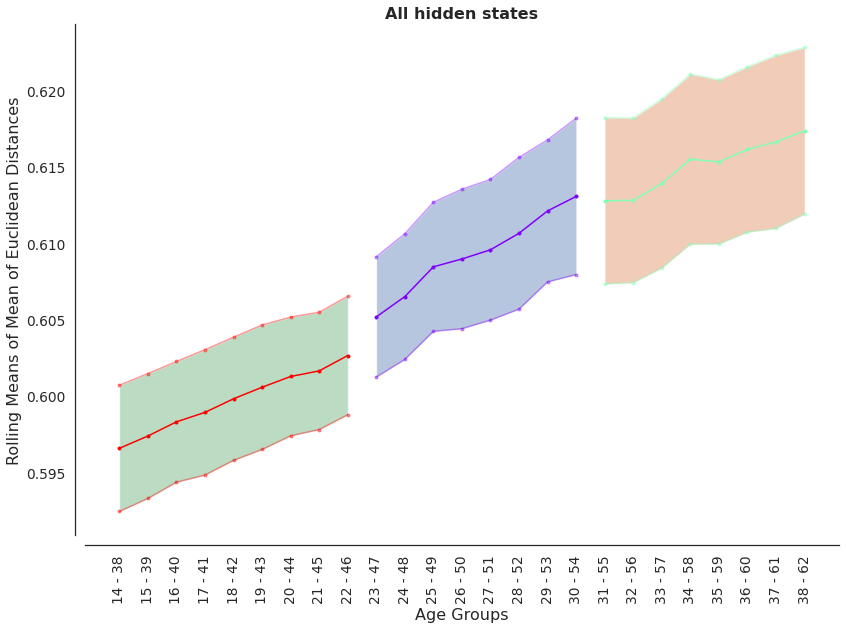

In [ ]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (color) in enumerate(colors):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i],
                 ".-", c=color)
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i] - 1.96*med.sem(axis=1)[hidden_states == i],
                 ".-", c=color, alpha=0.4)
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i] + 1.96*med.sem(axis=1)[hidden_states == i],
                 ".-", c=color, alpha=0.4)
    ax.fill_between(med.index.values[mask], med.mean(axis=1)[hidden_states == i] - 1.96*med.sem(axis=1)[hidden_states == i], 
                                             med.mean(axis=1)[hidden_states == i] + 1.96*med.sem(axis=1)[hidden_states == i], alpha=0.4)

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

ax.set_xticks(list(range(38,63)))
ax.set_xticklabels(['14 - 38', '15 - 39', '16 - 40', '17 - 41', '18 - 42', '19 - 43', '20 - 44', '21 - 45', '22 - 46', 
                     '23 - 47', '24 - 48', '25 - 49', '26 - 50', '27 - 51', '28 - 52', '29 - 53', '30 - 54', '31 - 55', 
                     '32 - 56', '33 - 57', '34 - 58', '35 - 59', '36 - 60', '37 - 61', '38 - 62'], rotation=90)
ax.set_title("All hidden states", fontsize=16, fontweight='demi')
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Mean of Euclidean Distances", fontsize=16)

plt.tight_layout()

In [ ]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=X_test.index)
          .join(X_test, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
states.head()

In [ ]:
med = pd.read_csv("rolling-euclidean-distances.csv", index_col=0)

In [ ]:
med.shape

(76, 25)

Means and vars of each hidden state
0th hidden state
mean =  [0.57880925 0.583982   0.61245975 0.6092155  0.60895325 0.591669
 0.582635   0.598554   0.5976965  0.59287075 0.59959925 0.59858525
 0.5965065  0.59870675 0.5814165  0.6136965  0.60041075 0.61134825
 0.580088   0.60183875 0.604794   0.60662425 0.5982165  0.602527
 0.59353725]
var =  [4.68495769e-06 1.43501550e-06 3.91988319e-06 3.19115425e-06
 1.29707819e-06 2.86733300e-06 9.76363650e-06 2.22799650e-06
 9.83974125e-06 1.80327419e-06 8.65578619e-06 1.42653569e-06
 5.92114125e-06 1.97186719e-06 3.89945325e-06 2.94216075e-06
 1.04947097e-05 3.89788519e-06 3.25241250e-06 4.42831769e-06
 2.31397950e-06 1.08457569e-06 2.08567875e-06 2.75330600e-06
 3.86087319e-06]

1th hidden state
mean =  [0.61380383 0.6154855  0.62299133 0.63231733 0.60049433 0.6002685
 0.5932075  0.62192667 0.6191915  0.6385355  0.62300517 0.62465433
 0.64127483 0.58514833 0.60087517 0.61955133 0.61385467 0.62675733
 0.59867767 0.61791917 0.611624   0.63137267 0

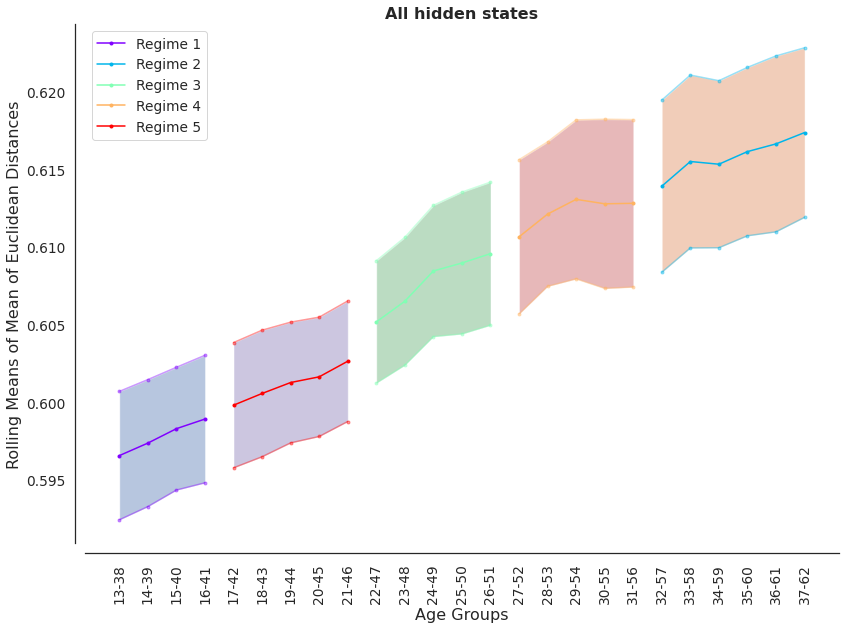

In [ ]:
import seaborn as sns
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

med = pd.read_csv("rolling-mean-euclidean-distances-cacd-agedb.csv", index_col=0)
# med = med

model = mix.GaussianMixture(n_components=5, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(med)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(med)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))
regimes = ['Regime 1', 'Regime 2', 'Regime 3', 'Regime 4', 'Regime 5']
for i, (color) in enumerate(colors):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i],
                 ".-", c=color, label=regimes[i])
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i] - 1.96*med.sem(axis=1)[hidden_states == i],
                 ".-", c=color, alpha=0.4)
    ax.plot(med.index.values[mask],
                 med.mean(axis=1)[hidden_states == i] + 1.96*med.sem(axis=1)[hidden_states == i],
                 ".-", c=color, alpha=0.4)
    ax.fill_between(med.index.values[mask], med.mean(axis=1)[hidden_states == i] - 1.96*med.sem(axis=1)[hidden_states == i], 
                                             med.mean(axis=1)[hidden_states == i] + 1.96*med.sem(axis=1)[hidden_states == i], alpha=0.4)

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

ax.legend()
ax.set_xticks(list(range(38,63,1)))
ax.set_xticklabels([str(i-25) + "-" + str(i) for i in range(38, 63, 1)], rotation=90)
ax.set_title("All hidden states", fontsize=16, fontweight='demi')
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Mean of Euclidean Distances", fontsize=16)

plt.tight_layout()

In [ ]:
med

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
38,0.579859,0.583507,0.610144,0.606847,0.609155,0.592834,0.578188,0.596957,0.594578,0.592014,...,0.612986,0.596201,0.610518,0.577901,0.603466,0.605006,0.606558,0.596970,0.601145,0.595543
39,0.576144,0.584031,0.612124,0.609852,0.609587,0.589744,0.582597,0.599031,0.595160,0.591939,...,0.611892,0.599084,0.614292,0.581907,0.600214,0.602887,0.606279,0.598718,0.601917,0.592751
40,0.578000,0.583352,0.612626,0.609291,0.608981,0.591020,0.586493,0.598246,0.599257,0.593689,...,0.614304,0.601920,0.610331,0.580924,0.599785,0.605904,0.606575,0.597526,0.604695,0.594668
41,0.581234,0.585038,0.614945,0.610872,0.608090,0.593078,0.583262,0.599982,0.601791,0.593841,...,0.615604,0.604438,0.610252,0.579620,0.603890,0.605379,0.607085,0.599652,0.602351,0.591187
42,0.582962,0.581359,0.610528,0.611226,0.609433,0.596272,0.587734,0.598748,0.603932,0.597789,...,0.615786,0.602076,0.612316,0.577895,0.603832,0.608260,0.606282,0.603345,0.599457,0.593885
43,0.585087,0.582882,0.613409,0.611882,0.608816,0.598474,0.588182,0.601431,0.600676,0.600460,...,0.616541,0.601393,0.613074,0.576979,0.604749,0.609135,0.606531,0.601988,0.601570,0.594964
44,0.587430,0.588226,0.614404,0.609520,0.607581,0.599356,0.589627,0.604137,0.598733,0.603021,...,0.616493,0.600776,0.614971,0.577820,0.605125,0.604695,0.606754,0.601656,0.601274,0.595345
45,0.592070,0.588752,0.615609,0.607838,0.607380,0.596613,0.589150,0.601169,0.596864,0.608083,...,0.613671,0.604497,0.613613,0.579644,0.605651,0.607696,0.611653,0.600360,0.602437,0.590812
46,0.591880,0.589124,0.611727,0.612128,0.609649,0.596784,0.593806,0.601387,0.598776,0.609996,...,0.616834,0.606786,0.616838,0.579174,0.601704,0.609809,0.610359,0.597382,0.603478,0.594864
47,0.597339,0.595139,0.610023,0.616025,0.613130,0.600961,0.593332,0.606858,0.601272,0.610045,...,0.614935,0.612406,0.613699,0.582133,0.599132,0.615433,0.614387,0.598584,0.605805,0.597059


In [ ]:
med

,26,27,28,29,30,31,32,33,34,35,...,92,93,94,95,96,97,98,99,100,101
0,0.506219,0.490455,0.479712,0.478077,0.498243,0.502662,0.515425,0.517613,0.507845,0.509385,...,0.569472,0.566350,0.574807,0.574502,0.572346,0.570681,0.559612,0.555139,0.563091,0.558695
1,0.495292,0.487493,0.486400,0.486110,0.503941,0.505167,0.508278,0.501154,0.504642,0.508202,...,0.573730,0.567055,0.575123,0.571296,0.566983,0.560689,0.551407,0.556986,0.567305,0.566960
2,0.487076,0.500881,0.511212,0.523157,0.532824,0.537998,0.535491,0.536410,0.542662,0.532912,...,0.582884,0.586751,0.586821,0.580106,0.586330,0.583869,0.587935,0.580678,0.572734,0.567922
3,0.454082,0.466513,0.457388,0.450789,0.467140,0.481283,0.488448,0.493841,0.497956,0.498304,...,0.590286,0.590036,0.586664,0.587278,0.582724,0.586305,0.582826,0.581156,0.578475,0.572524
4,0.528562,0.539716,0.540632,0.530512,0.529139,0.522841,0.511864,0.504900,0.504718,0.508451,...,0.568031,0.561935,0.564632,0.559234,0.554190,0.547480,0.559748,0.571099,0.561131,0.555925
5,0.474809,0.487699,0.477841,0.480718,0.473459,0.472094,0.474616,0.481071,0.478806,0.480685,...,0.582138,0.578674,0.574781,0.571838,0.572097,0.581894,0.575853,0.572346,0.564239,0.559366
6,0.489510,0.492738,0.481671,0.489704,0.482181,0.490881,0.488839,0.490294,0.498131,0.508012,...,0.588667,0.586366,0.584240,0.576643,0.574018,0.573318,0.570907,0.565706,0.556936,0.552103
7,0.484230,0.482428,0.489661,0.494009,0.505927,0.507272,0.508699,0.515383,0.515469,0.520825,...,0.585283,0.581331,0.577094,0.571893,0.568901,0.566551,0.581767,0.581053,0.582050,0.580781
8,0.498961,0.503788,0.510708,0.520931,0.527095,0.526189,0.532004,0.534022,0.540052,0.544256,...,0.564004,0.574379,0.570668,0.563033,0.566742,0.571060,0.586289,0.580209,0.577678,0.572938
9,0.490545,0.487228,0.480071,0.477999,0.489080,0.482968,0.481703,0.482755,0.489336,0.494491,...,0.578341,0.578371,0.576823,0.572096,0.570367,0.569221,0.562469,0.565337,0.559159,0.553554


In [ ]:
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("mean of means = ", model.means_[i].mean())
    print("range: ", min(model.means_[i]), max(model.means_[i]))
    print("std of means = ", model.means_[i].std())
    print("var = ", np.diag(model.covariances_[i]))
    print("mean of var = ", np.diag(model.covariances_[i]).mean())
    print("std of var = ", np.diag(model.covariances_[i]).std())
    print()

Means and vars of each hidden state
0th hidden state
mean =  [0.57880925 0.583982   0.61245975 0.6092155  0.60895325 0.591669
 0.582635   0.598554   0.5976965  0.59287075 0.59959925 0.59858525
 0.5965065  0.59870675 0.5814165  0.6136965  0.60041075 0.61134825
 0.580088   0.60183875 0.604794   0.60662425 0.5982165  0.602527
 0.59353725]
mean of means =  0.5977896199999998
range:  0.5788092499999997 0.6136964999999998
std of means =  0.010057793145894394
var =  [4.68495769e-06 1.43501550e-06 3.91988319e-06 3.19115425e-06
 1.29707819e-06 2.86733300e-06 9.76363650e-06 2.22799650e-06
 9.83974125e-06 1.80327419e-06 8.65578619e-06 1.42653569e-06
 5.92114125e-06 1.97186719e-06 3.89945325e-06 2.94216075e-06
 1.04947097e-05 3.89788519e-06 3.25241250e-06 4.42831769e-06
 2.31397950e-06 1.08457569e-06 2.08567875e-06 2.75330600e-06
 3.86087319e-06]
mean of var =  4.000750109999978e-06
std of var =  2.744684126272746e-06

1th hidden state
mean =  [0.61380383 0.6154855  0.62299133 0.63231733 0.6004943

In [ ]:
hidden_states

array([0, 0, 0, 0, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1])